In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
import datetime
#sns.set(color_codes=True)
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import statistics as st
sns.set_style('whitegrid', {'axes.linewidth' : 0.5})
from statsmodels.distributions.empirical_distribution import ECDF
import scipy
import gc
import collections

import sys
sys.path.append('../prepare_gustav/src/')

from gustav import ebi, ncbi, nlm, nih
from gustav import publications
from gustav import github
from gustav import access_framework
from gtfparse import read_gtf

In [2]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, Circle, EdgesAndLinkedNodes, TapTool, NodesAndLinkedEdges, OpenURL, Title
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
from bokeh.transform import linear_cmap

In [3]:
output_notebook()

Loading BokehJS ...

In [4]:
import networkx as nx

In [5]:
help(nx)

Help on package networkx:

NAME
    networkx

DESCRIPTION
    NetworkX
    
    NetworkX is a Python package for the creation, manipulation, and study of the
    structure, dynamics, and functions of complex networks.
    
    See https://networkx.org for complete documentation.

PACKAGE CONTENTS
    algorithms (package)
    classes (package)
    conftest
    convert
    convert_matrix
    drawing (package)
    exception
    generators (package)
    linalg (package)
    readwrite (package)
    relabel
    testing (package)
    tests (package)
    utils (package)

SUBMODULES
    adjacency
    adjlist
    algebraicconnectivity
    all
    approximation
    assortativity
    astar
    asteroidal
    atlas
    attracting
    attrmatrix
    beamsearch
    bethehessianmatrix
    betweenness
    betweenness_subset
    biconnected
    binary
    bipartite
    boundary
    breadth_first_search
    centrality
    chains
    chordal
    classic
    clique
    closeness
    cluster
    cographs
  

In [5]:
%%time
gene_info = ncbi.gene_info(taxon_ncbi=9606, mode='unambiguous_ensembl')

../prepare_gustav/src\gustav\utils.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_with_delimiter.drop(column, 1).reset_index(),
../prepare_gustav/src\gustav\utils.py:63: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  joined = joined.drop('helper_index', 1)


Wall time: 1.07 s


In [6]:
%%time
gene2pubmed = ncbi.gene2pubmed(taxon_ncbi=9606)

Wall time: 121 ms


In [7]:
%%time

ml = ncbi.pubmed(
    'main',
    ['pubmed_id', 'pubdate']   # there are many more columns, including abstracts
).rename(
    columns={'pubdate': 'year'}
).groupby('pubmed_id')['year'].min().reset_index()

Wall time: 11.7 s


In [8]:
%%time
gene2pubmed = pd.merge(gene2pubmed, ml, on='pubmed_id', how='left')

Wall time: 8.75 s


In [130]:
gene2pubmed_new = gene2pubmed.copy()

In [131]:
gene2pubmed_new = gene2pubmed_new[(gene2pubmed_new['year'] >= 2000) & (gene2pubmed_new['year'] <= 2018)]

In [132]:
%%time
valid_pubmed_ids = gene2pubmed_new['pubmed_id'].value_counts()

valid_pubmed_ids = valid_pubmed_ids[(valid_pubmed_ids > 1) & (valid_pubmed_ids <= 10)]

gene2pubmed_new = gene2pubmed_new[gene2pubmed_new['pubmed_id'].isin(valid_pubmed_ids.index)]

gene_count = gene2pubmed[(gene2pubmed['year'] >= 2000) & (gene2pubmed['year'] <= 2018)]['gene_ncbi'].value_counts()

genes_of_interest = gene_count[gene_count.index.isin(gene_info['gene_ncbi'])].index.values

Wall time: 278 ms


In [133]:
edge_df = gene2pubmed_new[gene2pubmed_new['gene_ncbi'].isin(genes_of_interest)][['gene_ncbi', 'pubmed_id']]
G = nx.from_edgelist(edge_df.values)

In [135]:
len(edge_df['gene_ncbi'].value_counts().index.values)

17755

In [136]:
B = nx.algorithms.bipartite.weighted_projected_graph(G, nodes=edge_df['gene_ncbi'].value_counts().index.values)

In [198]:
%%time
temporal_network = {}
for year in range(2000, 2019):
    
    gene2pubmed_new = gene2pubmed.copy()

    gene2pubmed_new = gene2pubmed_new[(gene2pubmed_new['year'] == year)]

    valid_pubmed_ids = gene2pubmed_new['pubmed_id'].value_counts()

    valid_pubmed_ids = valid_pubmed_ids[(valid_pubmed_ids > 1) & (valid_pubmed_ids <= 10)]

    gene2pubmed_new = gene2pubmed_new[gene2pubmed_new['pubmed_id'].isin(valid_pubmed_ids.index)]

    gene_count = gene2pubmed[(gene2pubmed['year'] >= 2000) & (gene2pubmed['year'] <= 2018)]['gene_ncbi'].value_counts()

    genes_of_interest = gene_count[gene_count.index.isin(gene_info['gene_ncbi'])].index.values

    edge_df = gene2pubmed_new[gene2pubmed_new['gene_ncbi'].isin(genes_of_interest)][['gene_ncbi', 'pubmed_id']]
    G = nx.from_edgelist(edge_df.values)

    len(edge_df['gene_ncbi'].value_counts().index.values)

    B_weighted = nx.algorithms.bipartite.weighted_projected_graph(G, nodes=edge_df['gene_ncbi'].value_counts().index.values)

    B_weighted.add_nodes_from(list(set(genes_of_interest) - set(B_weighted.nodes)))
    
    temporal_network[year] = B_weighted

Wall time: 12.2 s


In [180]:
degrees = nx.degree(temporal_network.get(2000))

In [203]:
# start from edge list of year-aggregated network
# scikit learn allows for balanced training set

19788

In [205]:
for year in range(2000,2018):
    degrees = nx.degree(temporal_network.get(year))
    deg_array = np.array(list(dict(degrees).values()))
    #print(year, np.mean(deg_array))
    print(year, len(temporal_network.get(year).edges))
    #sns.distplot(np.log10(deg_array+1), kde=False)

2000 12343
2001 14872
2002 19889
2003 19135
2004 19464
2005 19743
2006 19966
2007 22697
2008 27858
2009 30840
2010 32723
2011 28741
2012 28297
2013 29132
2014 28954
2015 27090
2016 25965
2017 23522


In [114]:
%%time
valid_pubmed_ids = gene2pubmed_new['pubmed_id'].value_counts()

valid_pubmed_ids = valid_pubmed_ids[(valid_pubmed_ids > 1) & (valid_pubmed_ids <= 10)]

gene2pubmed_new = gene2pubmed_new[gene2pubmed_new['pubmed_id'].isin(valid_pubmed_ids.index)]

gene_count = gene2pubmed[(gene2pubmed['year'] >= 2000) & (gene2pubmed['year'] <= 2018)]['gene_ncbi'].value_counts()

genes_of_interest = gene_count[gene_count.index.isin(gene_info['gene_ncbi'])].index[0:10].values

gene2pubmed_unstack = gene2pubmed_new[gene2pubmed_new['gene_ncbi'].isin(genes_of_interest)].groupby(['pubmed_id', 'gene_ncbi']).size().unstack()
gene2pubmed_unstack = gene2pubmed_unstack.fillna(0).astype(int)

co_occ = gene2pubmed_unstack.T.dot(gene2pubmed_unstack)
co_occ.values[tuple([np.arange(co_occ.shape[0])]*2)] = 0
G = nx.from_pandas_adjacency(co_occ)

# number of publications attribute
n_pubs = dict([(node, gene_count[node]) for node in list(G)])
nx.set_node_attributes(G, name='n_pubs', values=n_pubs)

# node size attribute
n_pubs_to_size = dict([(node, 0.3*np.sqrt(gene_count[node])) for node in list(G)])
nx.set_node_attributes(G, name='size', values=n_pubs_to_size)

# gene symbol attribute
symbols = dict([(node, gene_info.loc[gene_info['gene_ncbi'] == node]['symbol_ncbi'].values[0]) for node in list(G)])
nx.set_node_attributes(G, name='symbol', values=symbols)

# gene description attribute
full_names = dict([(node, gene_info.loc[gene_info['gene_ncbi'] == node]['description'].values[0]) for node in list(G)])
nx.set_node_attributes(G, name='description', values=full_names)

# weighted degree
degrees = dict(nx.degree(G, weight='weight'))
nx.set_node_attributes(G, name='w_degree', values=degrees)

# unweighted degree
degrees = dict(nx.degree(G))
nx.set_node_attributes(G, name='u_degree', values=degrees)

# betweeness centrality
bc = dict(nx.betweenness_centrality(G, weight='weight'))
nx.set_node_attributes(G, name='betweenness_centrality', values=bc)

# website
site = dict([(node, 'ncbi.nlm.nih.gov/gene/' + str(node)) for node in list(G)])
nx.set_node_attributes(G, name='NCBI', values=site)

Wall time: 220 ms


ValueError: Received invalid argument(s): weight

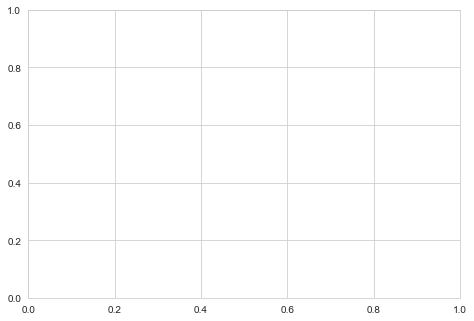

In [100]:
nx.draw(G, weight='weight')

In [61]:
adj_mat = nx.adjacency_matrix(G)

In [64]:
adj_mat.T @ adj_mat

<214625x214625 sparse matrix of type '<class 'numpy.intc'>'
	with 235113237 stored elements in Compressed Sparse Column format>

In [18]:
co_occ = gene2pubmed_unstack.T.dot(gene2pubmed_unstack)
co_occ.values[tuple([np.arange(co_occ.shape[0])]*2)] = 0
G = nx.from_pandas_adjacency(co_occ)

In [27]:
np.sum(np.sum(co_occ == 0)

4342

In [23]:
co_occ.shape

(100, 100)

In [28]:
pn_df = pd.read_csv('./proteostasis/pn_network_211212.csv')

name_to_entrez_dict = dict(zip(gene_info['symbol_ncbi'], gene_info['gene_ncbi']))

# get entrez for genes with only name
pn_df['gene_ncbi'] = pn_df['symbol_ncbi'].apply(lambda x: name_to_entrez_dict.get(x))

# drop those still without entrez
pn_df = pn_df.dropna(subset=['gene_ncbi'])

# insert Falses
pn_df[['cytosol','endoplasmic_reticulum', 'mitochondrial', 'ubq', 'autophagy',
       'ribosomal_qc', 'canon_chaperones', 'ambiguous']] = pn_df.loc[:, ['cytosol',
       'endoplasmic_reticulum', 'mitochondrial', 'ubq', 'autophagy',
       'ribosomal_qc', 'canon_chaperones', 'ambiguous']].fillna(False)

# remove ambiguous
pn_df = pn_df[~pn_df['ambiguous']]

# remove duplicates
pn_df = pn_df.groupby('gene_entrez').max().reset_index()

In [29]:
# neat str describing pn_role
pn_df['pn_role'] = ''

for index, row in pn_df.iterrows():
    
    pn_role = ''
    if row['canon_chaperones']:
        pn_role = pn_role + 'canon chaperone, '
    if row['cytosol']:
        pn_role = pn_role + 'cytosolic, '
    if row['endoplasmic_reticulum']:
        pn_role = pn_role + 'ER, '
    if row['mitochondrial']:
        pn_role = pn_role + 'ER, '
    if row['ubq']:
        pn_role = pn_role + 'ubiquitin system, '
    if row['autophagy']:
        pn_role = pn_role + 'autophagy, '
    if row['ribosomal_qc']:
        pn_role = pn_role + 'ribosome QC, '
        
    if np.sum(row[['cytosol','endoplasmic_reticulum', 'mitochondrial', 'ubq', 'autophagy',
       'ribosomal_qc', 'canon_chaperones']]) > 0:
        pn_role = pn_role[:-2]
        
    pn_df.loc[index, 'pn_role'] = pn_role

In [30]:
%%time
valid_pubmed_ids = gene2pubmed_new['pubmed_id'].value_counts()

valid_pubmed_ids = valid_pubmed_ids[(valid_pubmed_ids > 1) & (valid_pubmed_ids <= 10)]

gene2pubmed_new = gene2pubmed_new[gene2pubmed_new['pubmed_id'].isin(valid_pubmed_ids.index)]

gene_count = gene2pubmed[(gene2pubmed['year'] >= 2000) & (gene2pubmed['year'] <= 2018)]['gene_ncbi'].value_counts()

genes_of_interest = gene_count[(gene_count.index.isin(gene_info['gene_ncbi'])) & 
                               (gene_count.index.isin(pn_df['gene_ncbi']))].index.values

gene2pubmed_unstack = gene2pubmed_new[gene2pubmed_new['gene_ncbi'].isin(genes_of_interest)].groupby(['pubmed_id', 'gene_ncbi']).size().unstack()
gene2pubmed_unstack = gene2pubmed_unstack.fillna(0).astype(int)

co_occ = gene2pubmed_unstack.T.dot(gene2pubmed_unstack)
co_occ.values[tuple([np.arange(co_occ.shape[0])]*2)] = 0
G = nx.from_pandas_adjacency(co_occ)

# number of publications attribute
n_pubs = dict([(node, gene_count[node]) for node in list(G)])
nx.set_node_attributes(G, name='n_pubs', values=n_pubs)

# node size attribute
n_pubs_to_size = dict([(node, 1*np.sqrt(gene_count[node])) for node in list(G)])
nx.set_node_attributes(G, name='size', values=n_pubs_to_size)

# gene symbol attribute
symbols = dict([(node, gene_info.loc[gene_info['gene_ncbi'] == node]['symbol_ncbi'].values[0]) for node in list(G)])
nx.set_node_attributes(G, name='symbol', values=symbols)

# gene description attribute
full_names = dict([(node, gene_info.loc[gene_info['gene_ncbi'] == node]['description'].values[0]) for node in list(G)])
nx.set_node_attributes(G, name='description', values=full_names)

# role in proteostasis
pn_role = dict([(node, pn_df.loc[pn_df['gene_ncbi'] == node]['pn_role'].values[0]) for node in list(G)])
nx.set_node_attributes(G, name='pn_role', values=pn_role)

# weighted degree
degrees = dict(nx.degree(G, weight='weight'))
nx.set_node_attributes(G, name='w_degree', values=degrees)

# unweighted degree
degrees = dict(nx.degree(G))
nx.set_node_attributes(G, name='u_degree', values=degrees)

# betweeness centrality
bc = dict(nx.betweenness_centrality(G, weight='weight'))
nx.set_node_attributes(G, name='betweenness_centrality', values=bc)

# website
site = dict([(node, 'ncbi.nlm.nih.gov/gene/' + str(node)) for node in list(G)])
nx.set_node_attributes(G, name='NCBI', values=site)

Wall time: 2.91 s
